# Final Project EDA
---

## Plan
- Perform an exploratory data analysis. The output at the end of the notebook will be:
    - A list of clarifying questions
    - A rough plan for solving the task, specifying 3-5 basic steps and explaining each step in one or two sentences

## Objective
In order to optimize production costs, the steel plant Steelproof decided to reduce their energy consumption at the steel processing stage. You'll have to develop a model that will be able to predict the temperature of the metal.

### The Steps of Steel Processing

Steel is processed in a metal ladle that has a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks on the inside. Molten steel is poured into the ladle and heated to the desired temperature with graphite electrodes located on the lid.

Sulfur is removed from the metal through the process of desulfurization. The steel's chemical composition is corrected (by adding alloys in the form of bullions from the bunker with bulk materials or with the help of a wire feeder), and the necessary samples are taken.

Before alloying elements are included, the temperature of the steel is measured and its chemical composition is analyzed. The temperature is then raised for a few minutes, the alloying elements are added, and the alloy itself is purged with an inert gas. After that, the alloy is stirred and its temperature is measured again. This cycle repeats itself until the desired chemical composition and the optimal melting temperature are achieved.

The molten steel is then refined or transferred into a continuous casting machine which solidifies the steel into slabs.

---

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Models and Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

/Users/Ty/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data Description

- The data consists of files obtained from different sources:

    - `data_arc_en.csv` — electrode data
    - `data_bulk_en.csv` — bulk material supply data (volume)
    - `data_bulk_time_en.csv` — bulk material delivery data (time)
    - `data_gas_en.csv` — gas purge data
    - `data_temp_en.csv` — temperature measurement results
    - `data_wire_en.csv` — wire materials data (volume)
    - `data_wire_time_en.csv` — wire materials data (time)

- In each file, the `key` column contains the batch number.

- There may be several rows with the same `key` value in the files. These values correspond to different processing iterations.
---

### Data Upload

In [3]:
# Original Data
t1 = pd.read_csv('data_final_steel_en/data_arc_en.csv') # — electrode data
t2 = pd.read_csv('data_final_steel_en/data_bulk_en.csv') #— bulk material supply data (volume)
t3 = pd.read_csv('data_final_steel_en/data_bulk_time_en.csv') #— bulk material delivery data (time)
t4 = pd.read_csv('data_final_steel_en/data_gas_en.csv') #— gas purge data
t5 = pd.read_csv('data_final_steel_en/data_temp_en.csv') #— temperature measurement results
t6 = pd.read_csv('data_final_steel_en/data_wire_en.csv') #— wire materials data (volume)
t7 = pd.read_csv('data_final_steel_en/data_wire_time_en.csv') #— wire materials data (time)

# Data to work with
electrode = t1.copy()
bulk_supply_vol = t2.copy()
bulk_delivery_time = t3.copy()
gas = t4.copy()
temp = t5.copy()
wire_vol = t6.copy()
wire_time = t7.copy()

In [4]:
def data_view(df, add_hist=True):
    '''Quick way to look at and see the features in the different dataframes'''
    
    display(df.head())
    print(' ')
    print(df.info())
    print(' ')
    print(df.drop('key', axis=1).describe())
    print(' ')
    if add_hist:
        df.drop('key', axis=1).hist(figsize=(20,10))
        plt.show()
    else:
        pass

## Electrode EDA:
---

,key,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14876 non-null  int64  
 1   Arc heating start  14876 non-null  object 
 2   Arc heating end    14876 non-null  object 
 3   Active power       14876 non-null  float64
 4   Reactive power     14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
 
       Active power  Reactive power
count  14876.000000    14876.000000
mean       0.670441        0.452592
std        0.408159        5.878702
min        0.030002     -715.504924
25%        0.395297        0.290991
50%        0.555517        0.415962
75%        0.857034        0.637371
max        3.731596        2.676388
 


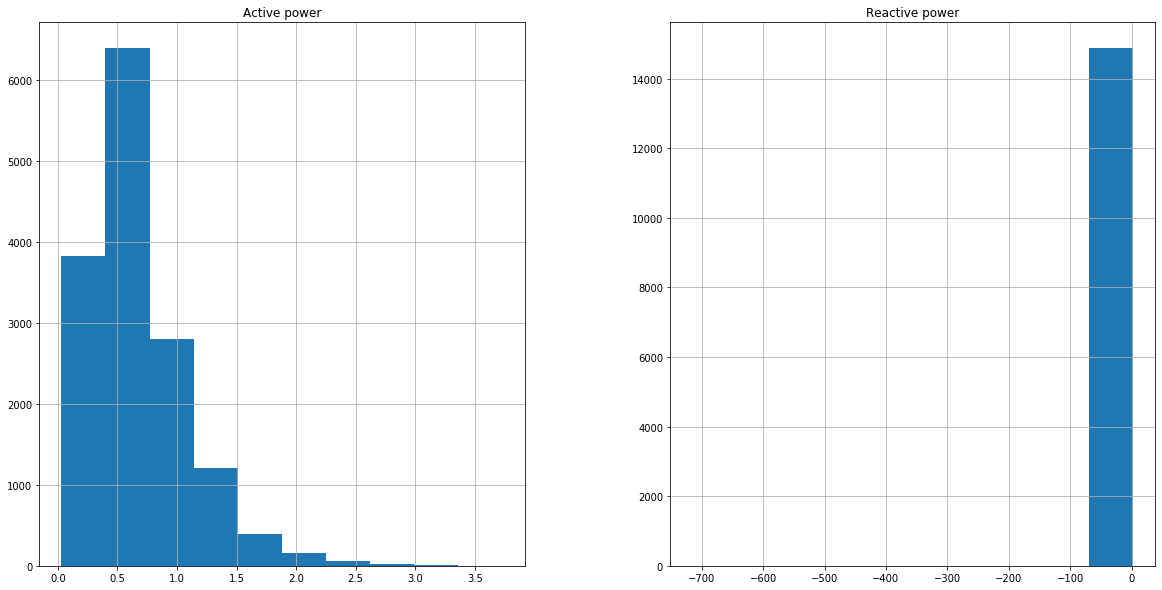

In [5]:
data_view(electrode)

Count of negative Reactive power rows: 1
Count of total Reactive power rows: 14876
 


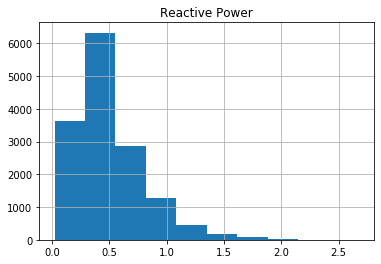

In [6]:
# fix outlier in 'Reactive Power' columns

print('Count of negative Reactive power rows:', len(electrode[electrode['Reactive power'] < 0]))
print('Count of total Reactive power rows:', len(electrode))
print(' ')

electrode = electrode[electrode['Reactive power'] >= 0]

electrode['Reactive power'].hist()
plt.title('Reactive Power')
plt.show()

In [7]:
def convert_cols(df):
    return [x.lower().replace(' ', '_') for x in list(df.columns)]

In [8]:
# Convert 'start' and 'end' to datetime dtypes
electrode['Arc heating start'] = pd.to_datetime(electrode['Arc heating start'])
electrode['Arc heating end'] = pd.to_datetime(electrode['Arc heating end'])

# column names
electrode.columns = convert_cols(electrode)

print(electrode.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14875 non-null  int64         
 1   arc_heating_start  14875 non-null  datetime64[ns]
 2   arc_heating_end    14875 non-null  datetime64[ns]
 3   active_power       14875 non-null  float64       
 4   reactive_power     14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB
None


#### Electrode Data Notes:
- No Null values
- Removed negative outlier in the 'reactive_power' column
- Converted heating time start and end to datetime dtypes
- Column Definitions
    - `key` = batch number
    - `arc_heating_start` = time when the electric arc begins to heat the metal
    - `arc_heating_end` = time when the electric arc stops heating the metal
    - `active_power` = the real power measured in watts
    - `reactive_power` = the useless power measured in VAR (volt-ampere reactive)

## Bulk Supply EDA
---

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
 
           Bulk 1      Bulk 2       Bulk 3       Bulk 4      Bulk 5  \
count  252.000000   22.000000  1298.000000  1014.000000   77.000000   
mean 

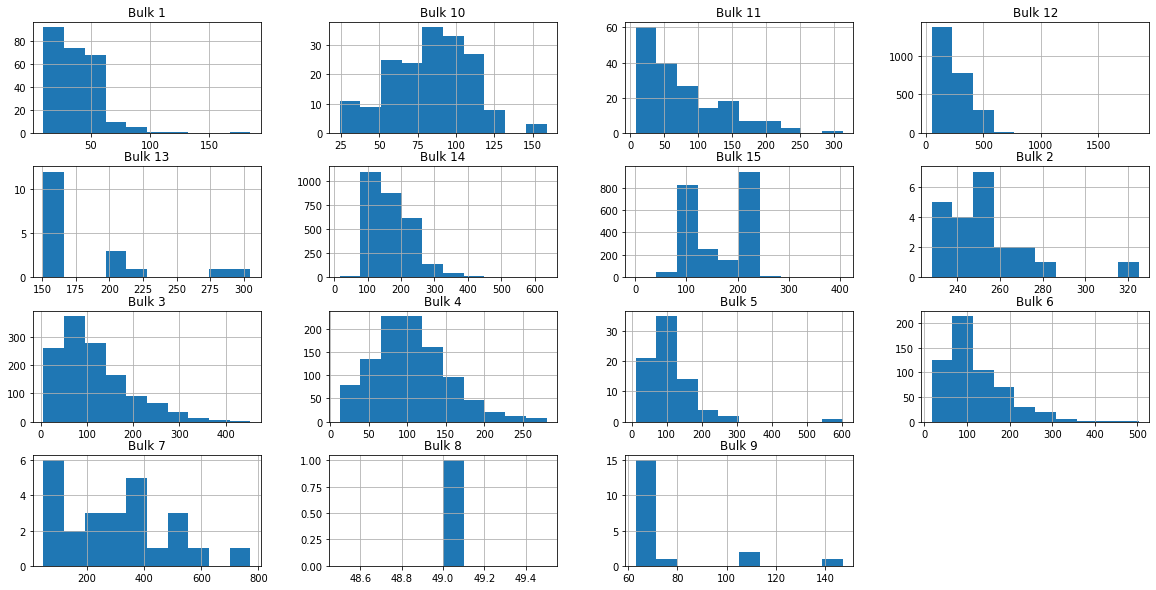

In [9]:
data_view(bulk_supply_vol)

In [10]:
# column names
bulk_supply_vol.columns = convert_cols(bulk_supply_vol)

# Converting Nulls to zeroes
bulk_supply_vol_zero = bulk_supply_vol.copy()
bulk_supply_vol_zero = bulk_supply_vol_zero.fillna(0)

bulk_supply_vol_zero.head(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


#### Bulk Supply Data Notes:
- Nulls
    - There are numerous null values, but they make sense since each column represents the supply of each bulk material and there is not always a supply.
    - I made a copy of the table to show null values as zeroes instead to be able to work with numeric values rather than null values
- Outliers
    - Each distribution for each bulk supply is different for each row/batch
    - Can expect wildly different values for each Bulk #
- Dtypes
    - All data types are correct
- Column Definitions
    - `key` = batch number
    - `Bulk #` = The bulk material supply

## Bulk Delivery EDA
---

In [11]:
data_view(bulk_delivery_time, add_hist=False)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
 
                     Bulk 1               Bulk 2               Bulk 3  \
count                   252                   22                 1298   
unique             

In [12]:
# convert Bulk # columns dtypes to datetime
for i in bulk_delivery_time.columns[1:]:
    bulk_delivery_time[i] = pd.to_datetime(bulk_delivery_time[i])

# column names
bulk_delivery_time.columns = convert_cols(bulk_delivery_time)

bulk_delivery_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


#### Bulk Delivery Data Notes:
- Nulls
    - Many NaT values that will need to be aware of during any analysis
- Dtypes
    - Convrted all `Bulk #` dtypes to timestamp
- Column Definitions
    - `key` = batch number
    - `Bulk #` = Bulk material delivery timestamp

## Gas EDA
---

,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Gas 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
 
             Gas 1
count  3239.000000
mean     11.002062
std       6.220327
min       0.008399
25%       7.043089
50%       9.836267
75%      13.769915
max      77.995040
 


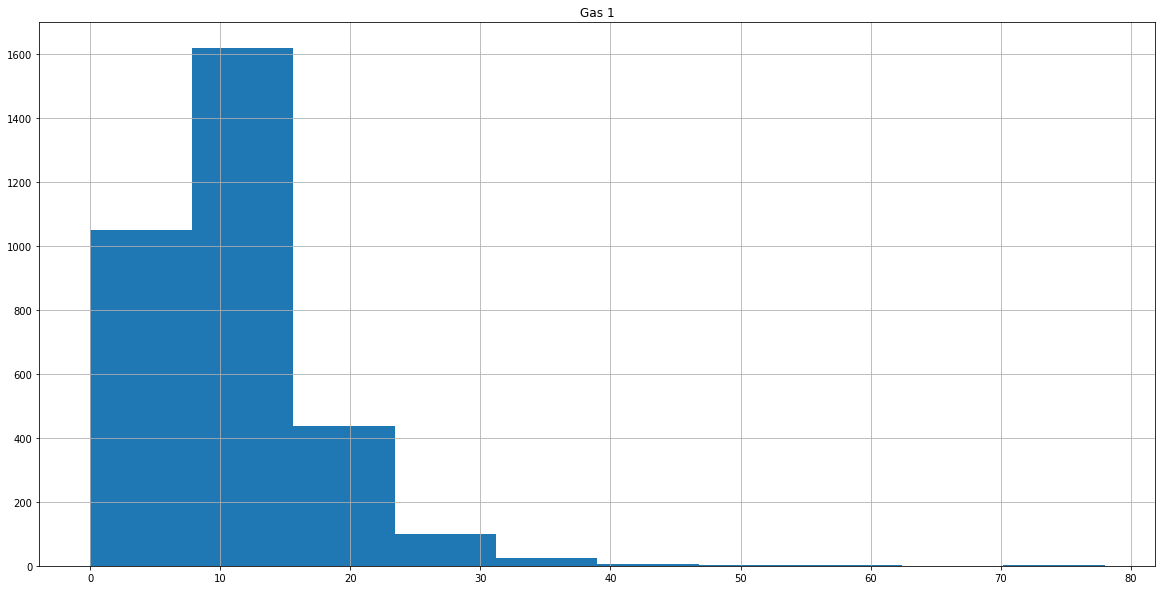

In [13]:
data_view(gas)

In [14]:
# column names
gas.columns = convert_cols(gas)

gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


#### Gas Data Notes:
- Nulls
    - No null values
- Outliers
    - Right skew in the gas data
    - This seems normal to me since the amount of gas purged can variate and cannot be negative
- Dtypes
    - All correct
- Column Definitions
    - `key` = batch number
    - `gas` = amount of gas purged in the batch

## Temp EDA
---

,key,Sampling time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            15907 non-null  int64  
 1   Sampling time  15907 non-null  object 
 2   Temperature    13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
 
        Temperature
count  13006.000000
mean    1591.840920
std       21.375851
min     1191.000000
25%     1581.000000
50%     1591.000000
75%     1601.000000
max     1705.000000
 


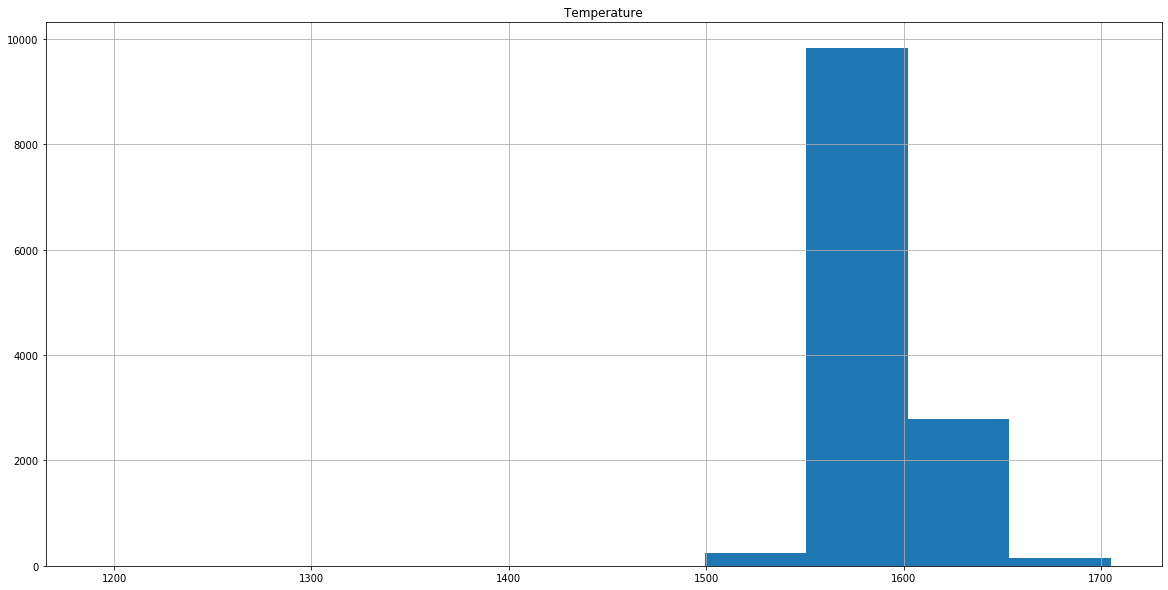

In [15]:
data_view(temp)

In [16]:
temp_nans = temp[temp['Temperature'].isna()]
len(temp_nans)

2901

In [17]:
# convert 'sampling time' dtype to timestamp
temp['Sampling time'] = pd.to_datetime(temp['Sampling time'])

# column names
temp.columns = convert_cols(temp)

# 2901 Nulls in temperature columns (new dfs with Nulls as zeros and Nulls dropped)
temp_temp = temp.copy()
temp_zero = temp_temp.fillna(0)
temp_no_nulls = temp_temp.dropna()

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            15907 non-null  int64         
 1   sampling_time  15907 non-null  datetime64[ns]
 2   temperature    13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [18]:
sum(temp_no_nulls['key'].value_counts() == 1)

741

**Seeing that there are 741 Keys with only one temperature, they should be dropped**

In [19]:
counts = temp_no_nulls['key'].value_counts()

temp_no_nulls = temp_no_nulls[temp_no_nulls['key'].isin(counts[counts > 1].index)]
temp_no_nulls['key'].value_counts().min()

2

#### Temp Data Notes:
- Nulls
    - 2901 Nulls in temperature columns
    - Made two new dfs where nulls were dropped or converted to 0's
- Outliers
    - Nothing too notable
    - Rather normal distribution with mean and median nearly equal
- Dtypes
    - Converted 'sampling_time' to datetime
- Column Definitions
    - `key` = batch number
    - `sampling_time` = timestamp of when the temperature was taken for that batch
    - `temperature` = temperature of the batch **(units not specified)**

## Wire Volume EDA
---

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
 
            Wire 1       Wire 2      Wire 3      Wire 4  Wire 5      Wire 6  \
count  3055.000000  1079.000000   63.000000   14.000000   1.000   73.000000   
mean    100.895853    50.577323  189.482681   57.442842  15.132   48.016974   
std      42.012518    39.320216   99.513444   28.824667     NaN   33.919845   
min       1.918800     0.030160    0.144144   24.148801  15.132    0.034

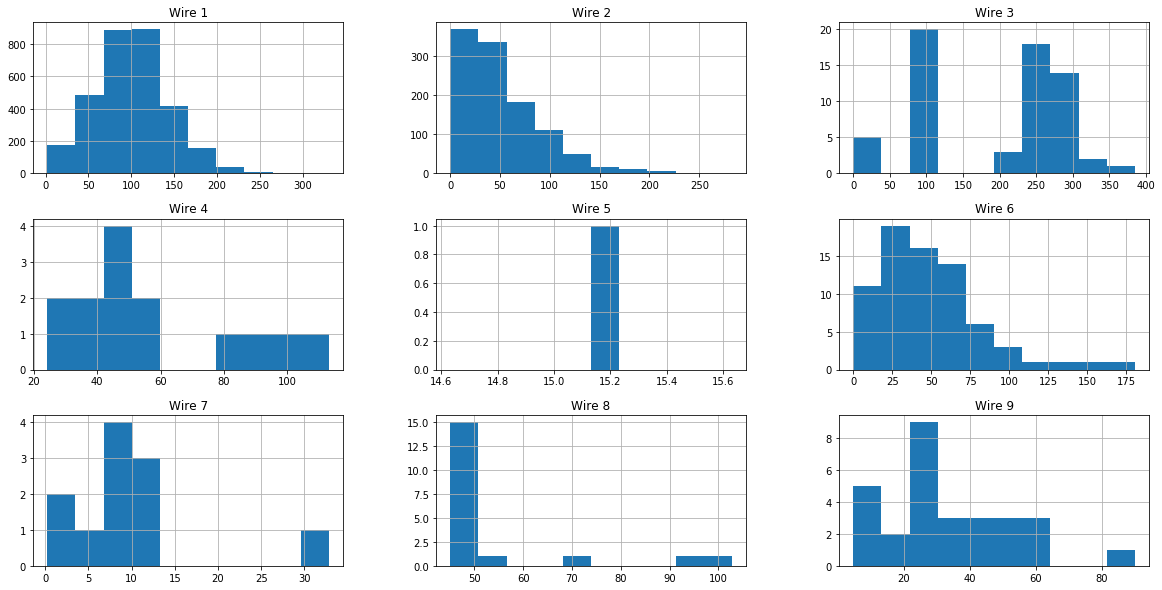

In [20]:
data_view(wire_vol)

In [21]:
# column names
wire_vol.columns = convert_cols(wire_vol)

# Converting Nulls to zeroes
wire_vol_zero = wire_vol.copy()
wire_vol_zero = wire_vol_zero.fillna(0)

wire_vol_zero.head(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Wire Volume Data Notes:
- This is very similar to the Bulk volume data
- Nulls
    - There are numerous null values, but they make sense since each column represents the wire volume which sometimes may be zero
    - I made a copy of the table to show null values as zeroes instead to be able to work with numeric values rather than null values
- Outliers
    - Each distribution for each bulk supply is different for each row/batch
    - Can expect wildly different values for each Wire Volume
- Dtypes
    - All data types are correct
- Column Definitions
    - `key` = batch number
    - `wire_#` = volume of the wire materials

## Wire Time EDA
---

In [22]:
data_view(wire_time, add_hist=False)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
 
                     Wire 1               Wire 2               Wire 3  \
count                  3055                 1079                   63   
unique                 3055                 1079                   63   
top     2019-08-04 11:56:39  2019-07-22 12:57:18  2019-06-10 14:05:33   
freq                      1                    1                    1   

                     Wire 4       

In [23]:
# convert Wire # columns dtypes to datetime
for i in wire_time.columns[1:]:
    wire_time[i] = pd.to_datetime(wire_time[i])

# column names
wire_time.columns = convert_cols(wire_time)

wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


#### Wire Time Data Notes:
- This is very similar to the Bulk time data
- Nulls
    - Many NaT values that will need to be aware of during any analysis
- Dtypes
    - Converted all `Wire #` dtypes to timestamp
- Column Definitions
    - `key` = batch number
    - `Wire #` = Wire feeder timestamp

### Plan for solving the task

1. Fully understand the task and gather all requirements from key stakeholders. Resolve any questions and remove any doubts.
2. Aggregate and merge data as necessary into a single frame. I will create or drop features as I see fit.
3. Split data into train, validate, and test. Test a handful of different models and select the best performing 3 based on preferred metric (to be confirmed by team leader)
4. Fine tune the top models be tweaking parameters. When the final model is chosen, measure performance against the test set
5. Prepare report including all necessary details with simple explanations and quality visuals. Keep in mind audience when completing the report.

## Combining the Data

In [24]:
# Grouping by key column in two of the datasets in order to merge data for training and testing
temp_grouped = temp_no_nulls.groupby('key').agg({'sampling_time':'first',
                                                 'temperature':['first', 'last']}).reset_index()
temp_grouped = pd.DataFrame(temp_grouped)
temp_grouped.columns = ['key', 'first_timestamp', 'first_temp', 'target_temp']

# Extract day of week and hour from initial timestamp
temp_grouped['first_sample_weekday'] = temp_grouped['first_timestamp'].dt.dayofweek
temp_grouped['first_sample_hour'] = temp_grouped['first_timestamp'].dt.hour

temp_grouped = temp_grouped.drop('first_timestamp', axis=1)

print(temp_grouped.head())
print('Number of Rows:', len(temp_grouped))
print('')

electrode_grouped = electrode[['key', 'active_power', 'reactive_power']].groupby('key').sum().reset_index()
electrode_grouped = pd.DataFrame(electrode_grouped)
electrode_grouped.columns = ['key', 'sum_active', 'sum_reactive']

print(electrode_grouped.head())

   key  first_temp  target_temp  first_sample_weekday  first_sample_hour
0    1      1571.0       1613.0                     4                 11
1    2      1581.0       1602.0                     4                 11
2    3      1596.0       1599.0                     4                 12
3    4      1601.0       1625.0                     4                 12
4    5      1576.0       1602.0                     4                 13
Number of Rows: 2475

   key  sum_active  sum_reactive
0    1    4.878147      3.183241
1    2    3.052598      1.998112
2    3    2.525882      1.599076
3    4    3.209250      2.060298
4    5    3.347173      2.252643


In [25]:
# Merge desired columns into one df
df = (temp_grouped.merge(electrode_grouped, how = 'left', on = 'key')
                 .merge(gas, how = 'left', on = 'key')
                 .merge(bulk_supply_vol, how = 'left', on = 'key')
                 .merge(wire_vol, how = 'left', on = 'key')
       )

df_zero = (temp_grouped.merge(electrode_grouped, how = 'left', on = 'key')
                 .merge(gas, how = 'left', on = 'key')
                 .merge(bulk_supply_vol_zero, how = 'left', on = 'key')
                 .merge(wire_vol_zero, how = 'left', on = 'key'))

df = pd.DataFrame(df)

display(df.head(2))
print(df.info())

,key,first_temp,target_temp,first_sample_weekday,first_sample_hour,sum_active,sum_reactive,gas_1,bulk_1,bulk_2,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4,11,4.878147,3.183241,29.749986,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1581.0,1602.0,4,11,3.052598,1.998112,12.555561,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2475 non-null   int64  
 1   first_temp            2475 non-null   float64
 2   target_temp           2475 non-null   float64
 3   first_sample_weekday  2475 non-null   int64  
 4   first_sample_hour     2475 non-null   int64  
 5   sum_active            2475 non-null   float64
 6   sum_reactive          2475 non-null   float64
 7   gas_1                 2473 non-null   float64
 8   bulk_1                199 non-null    float64
 9   bulk_2                13 non-null     float64
 10  bulk_3                965 non-null    float64
 11  bulk_4                814 non-null    float64
 12  bulk_5                53 non-null     float64
 13  bulk_6                443 non-null    float64
 14  bulk_7                14 non-null     float64
 15  bulk_8               

**Looking at this data I can drop the columns with a single non-null datapoint since it will likely have an adverse effect on my models.**

In [26]:
# Remove columns with a single non-null value
df_zero = df_zero.drop(['bulk_8', 'wire_5'], axis=1)

data = pd.DataFrame(df_zero).dropna()
display(data.head(2))
print(data.info())

,key,first_temp,target_temp,first_sample_weekday,first_sample_hour,sum_active,sum_reactive,gas_1,bulk_1,bulk_2,...,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4,11,4.878147,3.183241,29.749986,0.0,0.0,...,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,4,11,3.052598,1.998112,12.555561,0.0,0.0,...,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2329 non-null   int64  
 1   first_temp            2329 non-null   float64
 2   target_temp           2329 non-null   float64
 3   first_sample_weekday  2329 non-null   int64  
 4   first_sample_hour     2329 non-null   int64  
 5   sum_active            2329 non-null   float64
 6   sum_reactive          2329 non-null   float64
 7   gas_1                 2329 non-null   float64
 8   bulk_1                2329 non-null   float64
 9   bulk_2                2329 non-null   float64
 10  bulk_3                2329 non-null   float64
 11  bulk_4                2329 non-null   float64
 12  bulk_5                2329 non-null   float64
 13  bulk_6                2329 non-null   float64
 14  bulk_7                2329 non-null   float64
 15  bulk_9               

**Highest correlated Variables**

In [27]:
display(data.corr()['target_temp'].sort_values(ascending=False)[1:11])

wire_1          0.317575
sum_active      0.290434
bulk_12         0.267424
bulk_15         0.266414
first_temp      0.252443
sum_reactive    0.240980
bulk_4          0.187970
bulk_14         0.114617
bulk_10         0.061350
gas_1           0.059160
Name: target_temp, dtype: float64

## Model Building
---

In [28]:
# Split Data
train, v = train_test_split(data, test_size=0.4, random_state=123)
val, test = train_test_split(v, test_size=0.5, random_state=123)

# Separate Target column (last_temp)
x_train = train.drop('target_temp', axis=1)
y_train = train['target_temp']

x_val = val.drop('target_temp', axis=1)
y_val = val['target_temp']

x_test = test.drop('target_temp', axis=1)
y_test = test['target_temp']

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1397, 29)
(1397,)
(466, 29)
(466,)
(466, 29)
(466,)


In [29]:
# Feature Scaling
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Base Models
- Test initial models with cross validation

In [30]:
def init_cross_val(model_class, x=x_train, y=y_train):
    model = model_class
    cv_score = cross_val_score(model, X=x, y=y, scoring='neg_mean_absolute_error', cv=10)
    return model, cv_score

def show_scores(score):
    print('Scores:', -score)
    print('Mean:', -np.mean(score))

In [31]:
# Linear Regression

lin, lin_score = init_cross_val(LinearRegression())

show_scores(lin_score)

Scores: [5.9180176  5.95869367 6.99035677 8.05532312 6.36323051 6.089749
 5.86352114 7.37129597 6.02690546 6.70424345]
Mean: 6.534133669144057


In [32]:
# Logistic Regression

log, log_score = init_cross_val(LogisticRegression(solver='liblinear', random_state=123))

show_scores(log_score)

/Users/Ty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Scores: [7.48571429 8.18571429 8.42857143 8.65       8.13571429 8.02857143
 8.1        7.61151079 8.24460432 7.91366906]
Mean: 8.078406988694757


In [33]:
# Random Forest

rf, rf_score = init_cross_val(RandomForestRegressor(random_state=123))

show_scores(rf_score)

Scores: [6.1695     5.33321429 6.27885714 6.66921429 5.85607143 5.61042857
 5.83371429 7.15877698 5.59071942 6.51733813]
Mean: 6.101783453237411


In [34]:
# XGBoost

xgb, xgb_score = init_cross_val(xgb.XGBRegressor(random_state=123, verbosity=0))

show_scores(xgb_score)

Scores: [5.91774205 5.46670968 5.84543806 6.94195382 6.11937866 5.83753924
 5.72624337 7.10100221 5.78397682 6.22823811]
Mean: 6.096822202394335


In [35]:
# LGBM

lgboost, lgb_score = init_cross_val(lgb.LGBMRegressor(random_state=123))

show_scores(lgb_score)

Scores: [5.96722884 5.13106255 6.66229788 6.74755433 6.07520773 5.67777616
 5.72822973 6.55676149 5.63582106 6.43081835]
Mean: 6.061275811941897


In [36]:
# CatBoost

cb, cb_score = init_cross_val(CatBoostRegressor(random_state=123, silent=True))

show_scores(cb_score)

Scores: [5.94456992 4.97910965 6.00871834 6.82684037 5.79135968 5.85043845
 5.35496946 6.34986914 5.42713148 6.06596169]
Mean: 5.859896816368566


In [37]:
model_comps = {
    'Model Type':['Linear', 'Logistic', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'CV Score':[-np.mean(lin_score), -np.mean(log_score), -np.mean(rf_score), 
                -np.mean(xgb_score), -np.mean(lgb_score), -np.mean(cb_score)]
}

comps = pd.DataFrame(model_comps)
comps

,Model Type,CV Score
0,Linear,6.534134
1,Logistic,8.078407
2,Random Forest,6.101783
3,XGBoost,6.096822
4,LightGBM,6.061276
5,CatBoost,5.859897


### Early Model Results
- Based on the above table I will take the top three models and tune their parameters
    - CatBoost
    - LightGBM
    - XGBoost

## Tuning Models with GridSearch

In [38]:
# Setting up function to time cells and save to a variable

def my_time(start, end):
    diff_time = end - start
    return round(diff_time, 4)

In [39]:
def search_validate(model, params, X=x_train, y=y_train, xv=x_val, yv=y_val):
    search = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
    search.fit(X,y)
    best_params = search.best_params_
    
    mod = search.best_estimator_
    mod.fit(X,y)
    preds = mod.predict(xv)
    mae = mean_absolute_error(yv, preds)
    
    return best_params, mod, mae

In [40]:
# XGBoost
xg_start = time.time()

xg_grid = {
    'n_estimators':[50,100,250],
    'max_depth':[3,5,10,25],
    'learning_rate':[0.1,0.3,0.5]
}

xg_params, top_xg, xg_val_mae = search_validate(xgb, xg_grid)

print('Top Params:', xg_params)
print('Validation MAE:', xg_val_mae)

xg_end = time.time()
xg_time = my_time(xg_start, xg_end)

Top Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Validation MAE: 5.908752179452789


In [41]:
# Catboost
cb_start = time.time()

cb_grid = {
    'depth':[10,20],
    'iterations':[100,300,500],
    'learning_rate':[0.1,0.3,0.5]
}

cb_params, top_cb, cb_val_mae = search_validate(cb, cb_grid)

print('Top Params:', cb_params)
print('Validation MAE:', cb_val_mae)

cb_end = time.time()
cb_time = my_time(cb_start, cb_end)

/Users/Ty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/oblivious_tree_options.cpp:119: Maximum tree depth is 16

  FitFailedWarning)


Top Params: {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
Validation MAE: 5.926693719686594


In [42]:
# LightGBM
lg_start = time.time()

lg_grid = {
    'max_depth':[10,20,40,60],
    'num_leaves':[20,40,60,80,100]
}

lg_params, top_lg, lg_val_mae = search_validate(lgboost, lg_grid)

print('Top Params:', lg_params)
print('Validation MAE:', lg_val_mae)

lg_end = time.time()
lg_time = my_time(lg_start, lg_end)

Top Params: {'max_depth': 20, 'num_leaves': 20}
Validation MAE: 6.117287590595762


In [43]:
# Show comparison of models and scores

val_comps = {
    'Model':['XGBoost', 'CatBoost', 'LightGBM'],
    'Validation MAE':[xg_val_mae, cb_val_mae, lg_val_mae],
    'Wall Time to Run':[xg_time, cb_time, lg_time]
}

top_comps = pd.DataFrame(val_comps)
top_comps

,Model,Validation MAE,Wall Time to Run
0,XGBoost,5.908752,206.7201
1,CatBoost,5.926694,688.3305
2,LightGBM,6.117288,23.2351


In [44]:
# Run Final XGBoost model on Test Data

final_preds = top_xg.predict(x_test)
test_mae = mean_absolute_error(y_test, final_preds)

print('Model - XGBoost')
print('    Test Set MAE Score =', test_mae)

Model - XGBoost
    Test Set MAE Score = 6.064857581142704


## Solution Report:
---

- **What steps of the plan were performed and what steps were skipped (explain why)?**
    - I performed all steps of my plan except for the first one, which happens to not involve any code
    - I did not clarify some of my confusion around the process or ask enough clarifying questions
    - I felt as though I understood "enough" to get through, but with somemore clarification and focus I probably would have been more efficient in completing the code and completing the task

- **What difficulties did you encounter and how did you manage to solve them?**
    - Collecting and merging the data caused some of the most difficulty. Bringing together multiple dataframes in a way that was clean and concise was not easy

- **What were some of the key steps to solving the task?**
    - Collecting the right data that would be useful
    - I tried to take a funnel approach with my models, starting with many simple ones and then narrowing down the best and fine-tuning them to achieve the desired metric

- **What is your final model and what quality score does it have?**
    - My final model was an XGBoost Model with the following parameters:
        - max_depth=3
        - n_estimators=100
        - learning_rate=0.1
    - The MAE score on the test dataset was 6.06